In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout,Input, Add, ReLU, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import sklearn

import os
import cv2
from PIL import Image

### Importing Data

In [2]:
dir_train = "../input/iitgai-hackathon-2-2021-2022/"
os.listdir(dir_train)

['train_images', 'train_data.csv', 'test_images']

In [3]:
train_csv = pd.read_csv(dir_train + "train_data.csv")

In [4]:
train_csv.image_id = train_csv.image_id.astype(str) + '.jpg'

In [5]:
train_csv['file_path'] = dir_train + "train_images/train_images/" + train_csv['image_id']

In [6]:
train_csv = sklearn.utils.shuffle(train_csv,random_state=15)
train_csv

,image_id,label,file_path
596,123780103.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...
14009,2796815697.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...
1313,264213180.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...
12096,2412808296.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...
3838,762372916.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...
...,...,...,...
6528,1309142410.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...
16247,3254488090.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...
2693,532081653.jpg,0,../input/iitgai-hackathon-2-2021-2022/train_im...
8076,1612152421.jpg,3,../input/iitgai-hackathon-2-2021-2022/train_im...


In [7]:
BATCH_SIZE = 32
IMG_SIZE = 300
input_shape = (IMG_SIZE,IMG_SIZE,3)
classes = sorted(train_csv.label.unique())

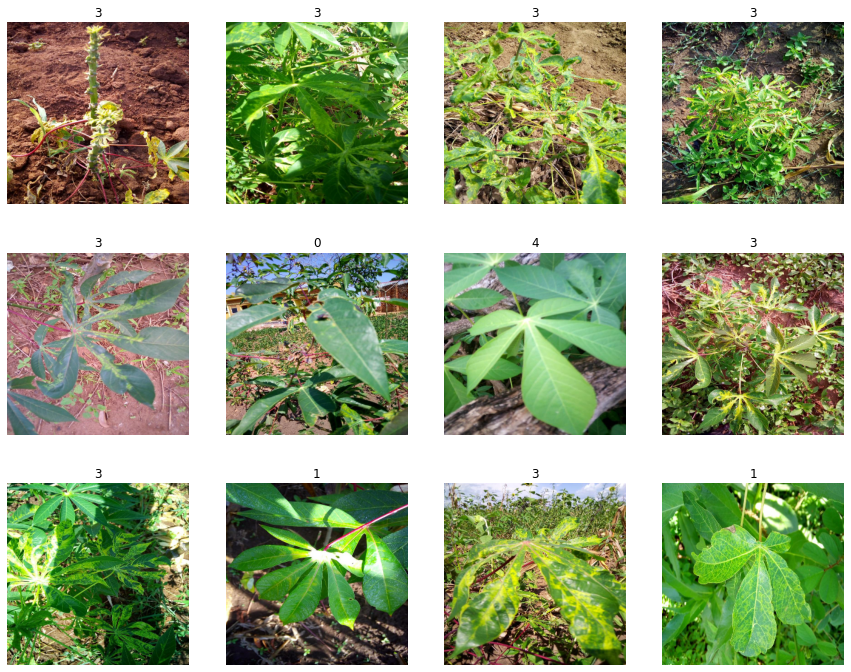

In [8]:
plt.figure(figsize=(15,12))
plot_sample = train_csv.sample(13).reset_index(drop=True)

for i in range(12):
    
    plt.subplot(3,4,i+1)
    
    img = cv2.imread(dir_train + 'train_images/train_images/' + plot_sample.image_id[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.axis('off')
    plt.imshow(img)
    plt.title(plot_sample.label[i])
    
plt.show()

### Preparing the training and valdation data

In [9]:
val_split = 0.2
total_train_items = int(len(train_csv)*(1 - val_split))
total_val_items = len(train_csv) - total_train_items
training_df = train_csv[:total_train_items]
val_df = train_csv[total_train_items:]

In [10]:
training_data = tf.data.Dataset.from_tensor_slices((training_df.file_path.values, training_df.label.values))
validation_data = tf.data.Dataset.from_tensor_slices((val_df.file_path.values, val_df.label.values))

2021-12-23 15:58:15.328027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 15:58:15.413138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 15:58:15.413826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 15:58:15.416361: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
def load_images_from_path(image_path, label):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

train = training_data.map(load_images_from_path, num_parallel_calls=AUTOTUNE)
val = validation_data.map(load_images_from_path, num_parallel_calls=AUTOTUNE)

In [12]:
train_batch = train.shuffle(buffer_size=1000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_batch = val.shuffle(buffer_size=1000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

#### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential(
[
        tf.keras.layers.experimental.preprocessing.RandomCrop(height=IMG_SIZE, width=IMG_SIZE),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2))
])

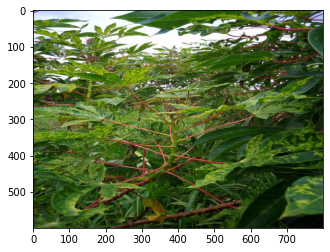

In [14]:
image = Image.open(train_csv.file_path[5])
plt.imshow(image)
plt.show()

In [15]:
image = tf.expand_dims(np.array(image),0)

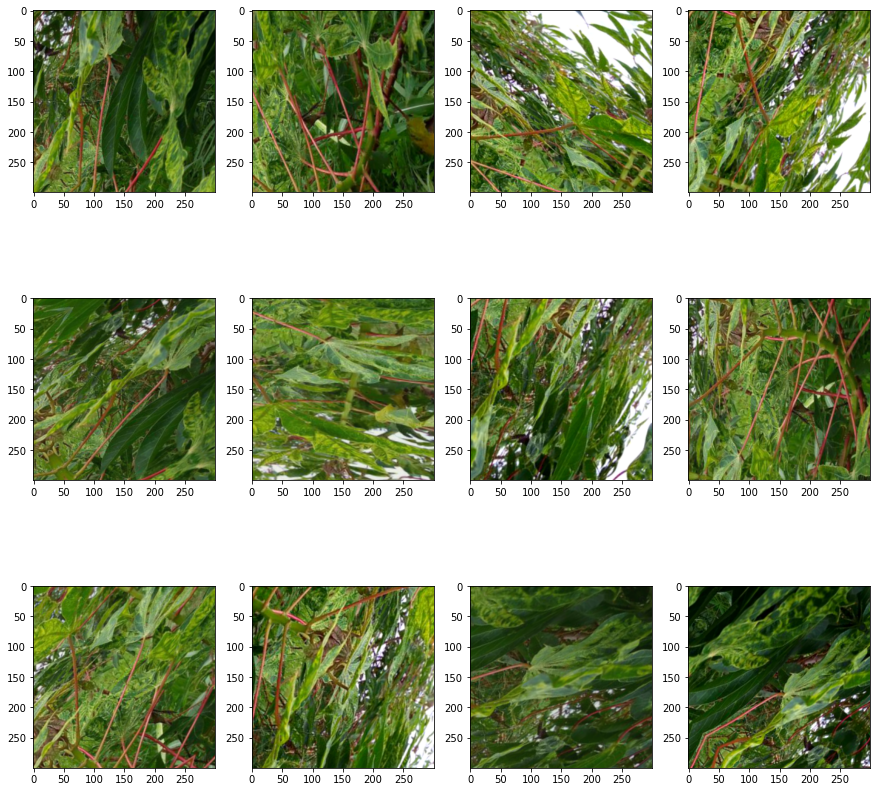

In [16]:
plt.figure(figsize = (15,15))

for i in range(12):
    
    aug = data_augmentation(image)
    plt.subplot(3,4,i+1)
    plt.imshow(aug[0])

In [17]:
adapt_data = tf.data.Dataset.from_tensor_slices(training_df.file_path.values)
def adapt_mode(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)
    return img

adapt_data = adapt_data.map(adapt_mode, num_parallel_calls=AUTOTUNE)
adapt_data_batches = adapt_data.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

## Model

### Efficient Net

In [18]:
eff_net = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top = False, input_shape = input_shape)

inputs = Input(shape = input_shape)

aug_image = data_augmentation(inputs)

eff_net = eff_net(aug_image)

pool = tf.keras.layers.GlobalAveragePooling2D()(eff_net)

drop = tf.keras.layers.Dropout(0.4)(pool)

outputs = tf.keras.layers.Dense(5, activation = 'softmax')(drop)

eff_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

eff_model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trai

In [19]:
%%time
eff_model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_data_batches)

2021-12-23 15:58:25.153077: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 2min 7s, sys: 45.4 s, total: 2min 53s
Wall time: 2min 12s


In [20]:
epochs = 10
decay_steps = int(round(len(training_df)/BATCH_SIZE))*epochs

cosine_decay = tf.keras.experimental.CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha = 0.3)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'eff_netb3.h5', monitor = 'val_acc', save_best_only = True)

callbacks = [checkpoint]

eff_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])

In [21]:
eff_history = eff_model.fit(train_batch,
                  epochs = epochs, 
                  validation_data=val_batch,
                  callbacks=callb acks)

Epoch 1/10


2021-12-23 16:00:53.698667: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


411/411 [==============================] - 361s 825ms/step - loss: 0.7255 - accuracy: 0.7352 - val_loss: 0.5971 - val_accuracy: 0.7759
Epoch 2/10
411/411 [==============================] - 332s 801ms/step - loss: 0.5324 - accuracy: 0.8105 - val_loss: 0.5615 - val_accuracy: 0.7896
Epoch 3/10
411/411 [==============================] - 332s 801ms/step - loss: 0.5021 - accuracy: 0.8249 - val_loss: 0.5507 - val_accuracy: 0.8015
Epoch 4/10
411/411 [==============================] - 334s 806ms/step - loss: 0.4653 - accuracy: 0.8354 - val_loss: 0.5489 - val_accuracy: 0.7975
Epoch 5/10
411/411 [==============================] - 336s 810ms/step - loss: 0.4480 - accuracy: 0.8418 - val_loss: 0.5146 - val_accuracy: 0.8136
Epoch 6/10
411/411 [==============================] - 337s 812ms/step - loss: 0.4359 - accuracy: 0.8478 - val_loss: 0.5150 - val_accuracy: 0.8139
Epoch 7/10
411/411 [==============================] - 336s 808ms/step - loss: 0.4244 - accuracy: 0.8522 - val_loss: 0.5298 - val_accura

In [22]:
eff_model.save('eff_netb3.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


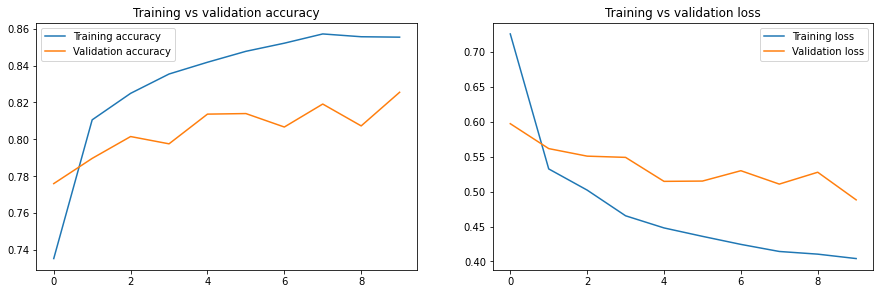

In [23]:
accuracy = eff_history.history['accuracy']
val_accuracy  = eff_history.history['val_accuracy']

loss = eff_history.history['loss']
val_loss = eff_history.history['val_loss']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

### Testing and Predicting

In [32]:
def scan_over_image(img_path, crop_size=300):
    
    img = Image.open(img_path)
    img_height, img_width = img.size
    img = np.array(img)
    
    y = np.random.randint(0,img_height-crop_size)
    x = np.random.randint(0,img_width-crop_size)

    x_img_origins = [0,img_width-crop_size]
    y_img_origins = [0,img_height-crop_size]
    img_list = []
    for x in x_img_origins:
        for y in y_img_origins:
            img_list.append(img[x:x+crop_size , y:y+crop_size,:])
            
    return np.array(img_list)

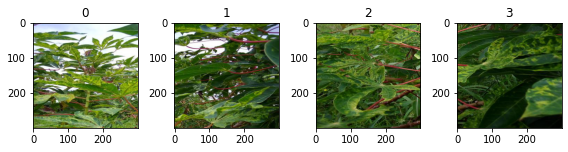

In [33]:
def display_samples(img_path):
    
    img_list = scan_over_image(img_path)
    sample_number = len(img_list)
    fig = plt.figure(figsize = (8,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(img_list[i])
        ax.set_title(str(i))
    plt.tight_layout()
    plt.show()

display_samples(train_csv['file_path'][5])

In [34]:
test_time_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2))
    ]
)

In [40]:
def predict_and_vote(image_filename, folder, TTA_runs=4):
    
    localised_predictions = []
    local_image_list = scan_over_image(folder+image_filename)
    for local_image in local_image_list:
        duplicated_local_image = tf.convert_to_tensor(np.array([local_image for i in range(TTA_runs)]))
        augmented_images = test_time_augmentation_layers(duplicated_local_image)
        
        predictions = eff_model.predict(augmented_images)
        localised_predictions.append(np.sum(predictions, axis=0))
        
    global_predictions = np.sum(np.array(localised_predictions),axis=0)
    final_prediction = np.argmax(global_predictions)
    
    return final_prediction

In [41]:
from tqdm import tqdm
def run_predictions_over_image_list(image_list, folder):
    predictions = []
    with tqdm(total=len(image_list)) as pbar:
        for image_filename in image_list:
            pbar.update(1)
            predictions.append(predict_and_vote(image_filename, folder))
    return predictions

In [42]:
test_folder = "../input/iitgai-hackathon-2-2021-2022/test_images/test_images/"

In [43]:
test_list = tf.io.gfile.listdir(test_folder)

In [44]:
final_pred = run_predictions_over_image_list(test_list, test_folder)

100%|██████████| 4981/4981 [33:13<00:00,  2.50it/s]


In [46]:
data_eff = {
    'image_id': test_list,
    'label': final_pred
}
result_eff = pd.DataFrame(data_eff)

result_eff['image_id'] = result_eff['image_id'].str.replace(".jpg", "")
result_eff['image_id'] = result_eff['image_id'].astype(int)

result_eff.to_csv('sub_effb3.csv', index=False)
result_eff

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


,image_id,label
0,4201965605,3
1,3459977804,3
2,4054194563,3
3,3977938536,3
4,3709602808,3
...,...,...
4976,3899993787,4
4977,3414625841,3
4978,3983529541,4
4979,3299560037,3
